In [1]:
!pip install tensorflow-gpu==2.0.0b1

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
words = ['good', 'bad', 'worse', 'so good']
y_data = [1, 0, 0, 1] # 1 for positive, 0 for negative

# creating a toekn dictionary
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

In [4]:
print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [0]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda word: [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

In [6]:
print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [7]:
pad_sequences = keras.preprocessing.sequence.pad_sequences

max_sequence = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post', truncating = 'post')

print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


In [8]:
import numpy as np

input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))

print("input_dim", input_dim)
print("output_dim", output_dim)


hidden_size = 10
num_classes = 2

def create_model():
  model = keras.Sequential()
  model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                             trainable=False, mask_zero=True, input_length=max_sequence,
                             embeddings_initializer=keras.initializers.Constant(one_hot)))
  model.add(layers.SimpleRNN(units=hidden_size))
  model.add(layers.Dense(units=num_classes))

  return model

input_dim 11
output_dim 11


In [9]:
model = create_model()

W0626 11:57:26.947603 140537562560384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:3868: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


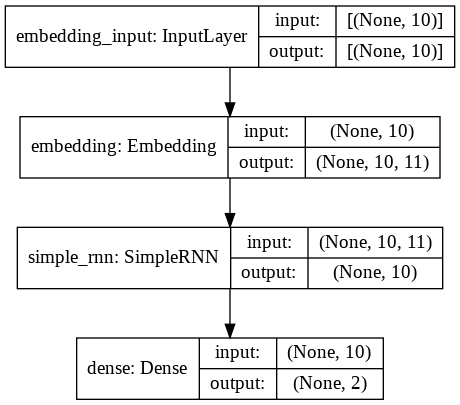

In [11]:
keras.utils.plot_model(model, 'Basic_RNN_many_to_one.png', show_shapes=True)

In [0]:
def loss_fn(model, x, y):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=model(x))
    loss = tf.reduce_mean(loss, axis=-1)
    return loss

In [0]:
lr = 1e-2
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(lr)

In [0]:
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(4)
tr_dataset = tr_dataset.batch(batch_size)

In [15]:
print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


In [16]:
tr_loss_hist = []

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0
  
  for x_mb, y_mb in tr_dataset:
    with tf.GradientTape() as tape:
      tr_loss = loss_fn(model, x_mb, y_mb)
    grads = tape.gradient(tr_loss, model.variables)
    opt.apply_gradients(zip(grads, model.variables))
    
    avg_tr_loss += tr_loss
    tr_step += 1
  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
  if (epoch+1) % 5 == 0:
    print('epoch: {:3d}, tr_loss: {:.3f}'.format(epoch+1, avg_tr_loss))

epoch:   5, tr_loss: 0.237
epoch:  10, tr_loss: 0.052
epoch:  15, tr_loss: 0.015
epoch:  20, tr_loss: 0.007
epoch:  25, tr_loss: 0.004
epoch:  30, tr_loss: 0.003


In [17]:
yhat = model.predict(x_data)
print(yhat)


yhat = np.argmax(yhat, axis = -1)
print(yhat)


print('acc: {:.2%}'.format(np.mean(yhat==y_data)))

[[-3.4012244  2.2721198]
 [ 3.119606  -2.5069082]
 [ 3.821534  -2.3967073]
 [-3.5216377  2.1792076]]
[1 0 0 1]
acc: 100.00%


In [18]:
tf.__version__

'2.0.0-beta1'